In [114]:
import numpy as np
import random
import tsplib95

def load_tsp_data(filename):
    return tsplib95.load(filename)

def create_route(problem):
    return np.random.permutation(range(1, problem.dimension + 1))

def initialize_population(pop_size, problem):
    population = [create_route(problem) for _ in range(pop_size)]
    print(f"Initialization complete. Population size: {len(population)}")  # Debugging print
    return population

def calculate_fitness(route, problem):
    if route.size == 0:
        return float('inf')

    adjusted_route = [city - 1 for city in route]  # Adjust for 1-based indexing

    total_distance = 0
    for i in range(len(adjusted_route)):
        start_city = adjusted_route[i]
        end_city = adjusted_route[(i + 1) % len(adjusted_route)]

        # Ensure indices are within the valid range
        if 0 <= start_city < problem.dimension and 0 <= end_city < problem.dimension:
            total_distance += problem.get_weight(start_city + 1, end_city + 1)  # Adjust for 1-based indexing
        else:
            print("Invalid index in route:", start_city, end_city)

    return total_distance


# Tournament Selection
def tournament_selection(population, problem, k=3):
    selected = []
    for _ in range(len(population)):
        contenders = random.sample(population, k)
        best = min(contenders, key=lambda route: calculate_fitness(route, problem))
        selected.append(best)
    return selected

# Roulette Wheel Selection
def roulette_wheel_selection(population, problem):
    fitness_values = [calculate_fitness(route, problem) for route in population]
    max_fitness = max(fitness_values)
    adjusted_fitness = [max_fitness - fitness for fitness in fitness_values]
    total_fitness = sum(adjusted_fitness)
    selection_probs = [f / total_fitness for f in adjusted_fitness]
    selected_indices = np.random.choice(len(population), size=len(population), p=selection_probs)
    return [population[i] for i in selected_indices]

# Partially Mapped Crossover (PMX)
def partially_mapped_crossover(parent1, parent2):
    parent1, parent2 = list(parent1), list(parent2)
    size = len(parent1)
    child = [-1] * size
    start, end = sorted(random.sample(range(size), 2))

    # Mapping for crossover
    mapping = {}

    for i in range(start, end + 1):
        child[i] = parent1[i]
        mapping[parent1[i]] = parent2[i]

    for i in range(size):
        if child[i] == -1:
            if parent2[i] not in mapping:
                child[i] = parent2[i]
            else:
                # Follow the mapping until an unmapped element is found
                mapped = parent2[i]
                while mapped in mapping:
                    mapped = mapping[mapped]
                child[i] = mapped

    return np.array(child)


# Order Crossover (OX)
def order_crossover(parent1, parent2):
    size = len(parent1)
    child = [-1] * size
    start, end = sorted(random.sample(range(size), 2))
    child[start:end + 1] = parent1[start:end + 1]
    p2_index = 0
    for i in range(size):
        if child[i] == -1:
            while parent2[p2_index] in child:
                p2_index += 1
            child[i] = parent2[p2_index]
            p2_index += 1
    return child

# Swap Mutation
def swap_mutation(route, mutation_rate):
    mutated_route = route.copy()
    for i in range(len(mutated_route)):
        if random.random() < mutation_rate:
            swap_idx = random.randint(0, len(mutated_route) - 1)
            mutated_route[i], mutated_route[swap_idx] = mutated_route[swap_idx], mutated_route[i]
    return mutated_route

# Inversion Mutation
def inversion_mutation(route, mutation_rate):
    mutated_route = route.copy()
    if random.random() < mutation_rate:
        start, end = sorted(random.sample(range(len(mutated_route)), 2))
        mutated_route[start:end+1] = reversed(mutated_route[start:end+1])
    return mutated_route

# Elitism
def elitism(population, problem, elite_size=1):
    sorted_population = sorted(population, key=lambda route: calculate_fitness(route, problem))
    return sorted_population[:elite_size]

# Dynamic Mutation Rate
def dynamic_mutation_rate(initial_rate, generation, max_generations):
    return initial_rate * (1 - (generation / max_generations))

def genetic_algorithm(problem, pop_size, generations, initial_mutation_rate, elite_size):
    if pop_size % 2 != 0:
        pop_size += 1

    population = initialize_population(pop_size, problem)
    best_route = None
    best_distance = float('inf')

    for generation in range(generations):
        current_mutation_rate = dynamic_mutation_rate(initial_mutation_rate, generation, generations)
        selected = tournament_selection(population, problem)
        children = []

        for i in range(0, len(selected) - 1, 2):
            child1 = partially_mapped_crossover(selected[i], selected[i + 1])
            child2 = partially_mapped_crossover(selected[i + 1], selected[i])
            children.extend([child1, child2])
        mutated_children = [swap_mutation(child, current_mutation_rate) for child in children]
        elites = elitism(population, problem, elite_size)
        population = elites + mutated_children
        for route in population:
            distance = calculate_fitness(route, problem)
            if distance < best_distance:
                best_route = route
                best_distance = distance
        print(f"Generation {generation}, Best Distance: {best_distance}")  # Debugging print

    return best_route, best_distance

# Execution Block
tsp_file_path = "/Users/mwr/Downloads/NEC_A4/att48.tsp.txt"  
problem = load_tsp_data(tsp_file_path)

# Define 5 different test cases
test_cases = [
    (50, 2, 0.001, 2),
    (50, 4, 0.001, 4),
    (100, 8, 0.001, 8),
    (100, 16, 0.001, 16),
    (200, 44, 0.001, 88)
]

# Dictionary to store results
test_results = {}

# Run each test case
for test in test_cases:
    pop_size, generations, mutation_rate, elite_size = test
    best_route, best_distance = genetic_algorithm(problem, pop_size, generations, mutation_rate, elite_size)
    test_results[test] = {"route": best_route, "distance": best_distance}

# Saving the results to a file
with open("ga_tsp_test_results_att48.txt", "w") as file:
    for params, result in test_results.items():
        file.write(f"Params: {params}, Best Route: {result['route']}, Total Distance: {result['distance']}\n")

print("All test results saved to 'ga_tsp_test_results_att48.txt'.")

Initialization complete. Population size: 50
Generation 0, Best Distance: 43307
Generation 1, Best Distance: 40661
Initialization complete. Population size: 50
Generation 0, Best Distance: 41367
Generation 1, Best Distance: 38056
Generation 2, Best Distance: 36564
Generation 3, Best Distance: 36564
Initialization complete. Population size: 100
Generation 0, Best Distance: 39786
Generation 1, Best Distance: 36850
Generation 2, Best Distance: 35598
Generation 3, Best Distance: 35598
Generation 4, Best Distance: 33555
Generation 5, Best Distance: 31284
Generation 6, Best Distance: 30625
Generation 7, Best Distance: 30068
Initialization complete. Population size: 100
Generation 0, Best Distance: 38700
Generation 1, Best Distance: 38700
Generation 2, Best Distance: 37290
Generation 3, Best Distance: 36123
Generation 4, Best Distance: 34994
Generation 5, Best Distance: 34879
Generation 6, Best Distance: 34243
Generation 7, Best Distance: 33269
Generation 8, Best Distance: 32744
Generation 9,

In [116]:
problem = load_tsp_data(tsp_file_path)
nodes = list(problem.get_nodes())
print(nodes)  # This should print the list of nodes


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]


In [150]:
import numpy as np
import random
import tsplib95

# Load TSP data from a file
def load_tsp_data(filename):
    return tsplib95.load(filename)

# Create a random route
def create_route(problem):
    return np.random.permutation(range(1, problem.dimension + 1))

# Initialize a population of routes
def initialize_population(pop_size, problem):
    return [create_route(problem) for _ in range(pop_size)]

# Calculate the total distance of a route
def calculate_fitness(route, problem):
    adjusted_route = [city - 1 for city in route]
    total_distance = 0
    for i in range(len(adjusted_route)):
        start_city = adjusted_route[i]
        end_city = adjusted_route[(i + 1) % len(adjusted_route)]
        total_distance += problem.get_weight(start_city + 1, end_city + 1)  # Adjust for 1-based indexing
    return total_distance

# Tournament Selection
def tournament_selection(population, problem, k=3):
    selected = []
    for _ in range(len(population)):
        contenders = random.sample(population, k)
        best = min(contenders, key=lambda route: calculate_fitness(route, problem))
        selected.append(best)
    return selected

# Roulette Wheel Selection
def roulette_wheel_selection(population, problem):
    fitness_values = [calculate_fitness(route, problem) for route in population]
    max_fitness = max(fitness_values)
    adjusted_fitness = [max_fitness - fitness for fitness in fitness_values]
    total_fitness = sum(adjusted_fitness)
    selection_probs = [f / total_fitness for f in adjusted_fitness]
    selected_indices = np.random.choice(len(population), size=len(population), p=selection_probs)
    return [population[i] for i in selected_indices]

# Partially Mapped Crossover (PMX)
def partially_mapped_crossover(parent1, parent2):
    parent1, parent2 = list(parent1), list(parent2)
    size = len(parent1)
    child = [-1] * size
    start, end = sorted(random.sample(range(size), 2))

    # Mapping for crossover
    mapping = {}
    for i in range(start, end + 1):
        child[i] = parent1[i]
        mapping[parent1[i]] = parent2[i]

    for i in range(size):
        if child[i] == -1:
            if parent2[i] not in mapping:
                child[i] = parent2[i]
            else:
                # Follow the mapping until an unmapped element is found
                mapped = parent2[i]
                while mapped in mapping:
                    mapped = mapping[mapped]
                child[i] = mapped
    return np.array(child)

# Order Crossover (OX)
def order_crossover(parent1, parent2):
    size = len(parent1)
    child = [-1] * size
    start, end = sorted(random.sample(range(size), 2))
    child[start:end + 1] = parent1[start:end + 1]
    p2_index = 0
    for i in range(size):
        if child[i] == -1:
            while parent2[p2_index] in child:
                p2_index += 1
            child[i] = parent2[p2_index]
            p2_index += 1
    return child

# Swap Mutation
#def swap_mutation(route, mutation_rate):
 #   mutated_route = route.copy()
  #  for i in range(len(mutated_route)):
   #     if random.random() < mutation_rate:
    #        swap_idx = random.randint(0, len(mutated_route) - 1)
     #       mutated_route[i], mutated_route[swap_idx] = mutated_route[swap_idx], mutated_route[i]
      #      return mutated_route

#Scramble Mutation
def displacement_mutation(route):
    mutated_route = route.copy()
    start, end = sorted(random.sample(range(len(route)), 2))
    displaced_section = mutated_route[start:end+1]
    mutated_route = mutated_route[:start] + mutated_route[end+1:]
    insert_position = random.randint(0, len(mutated_route))
    mutated_route = mutated_route[:insert_position] + displaced_section + mutated_route[insert_position:]
    return mutated_route


#Elitism
def elitism(population, problem, elite_size=1):
    sorted_population = sorted(population, key=lambda route: calculate_fitness(route, problem))
    return sorted_population[:elite_size]

#Dynamic Mutation Rate
def dynamic_mutation_rate(initial_rate, generation, max_generations):
    return initial_rate * (1 - (generation / max_generations))

def genetic_algorithm(problem, pop_size, generations, initial_mutation_rate, elite_size):
    population = initialize_population(pop_size, problem)
    best_route = None
    best_distance = float('inf')

    for generation in range(generations):
        current_mutation_rate = dynamic_mutation_rate(initial_mutation_rate, generation, generations)
        selected = tournament_selection(population, problem)
        children = []

        for i in range(0, len(selected) - 1, 2):
            child1 = partially_mapped_crossover(selected[i], selected[i + 1])
            child2 = partially_mapped_crossover(selected[i + 1], selected[i])
            children.extend([child1, child2])

        mutated_children = [swap_mutation(child, current_mutation_rate) for child in children]
        elites = elitism(population, problem, elite_size)
        population = elites + mutated_children

        for route in population:
            distance = calculate_fitness(route, problem)
            if distance < best_distance:
                best_route = route
                best_distance = distance
                # Ensure the route starts and ends at the same city
                if best_route[0] != best_route[-1]:
                    best_route = np.append(best_route, best_route[0])
                    return best_route, best_distance

#Execution Block
tsp_file_path = "/Users/mwr/Downloads/NEC_A4/dantzig42.tsp.txt"
problem = load_tsp_data(tsp_file_path)

#Define test cases
test_cases = [
(50, 100, 0.01, 1),
(100, 200, 0.01, 2),
(200, 300, 0.01, 5),
(300, 40, 0.005, 15),
(1000, 400, 0.0001, 300)
]

#Dictionary to store results
test_results = {}

#Run each test case
for test in test_cases:
    pop_size, generations, mutation_rate, elite_size = test
    best_route, best_distance = genetic_algorithm(problem, pop_size, generations, mutation_rate, elite_size)
    test_results[test] = {"route": best_route, "distance": best_distance}

#Saving the results to a file
with open("ga_tsp_test_results_dantzig42.txt", "w") as file:
    for params, result in test_results.items():
        file.write(f"Params: {params}, Best Route: {result['route']}, Total Distance: {result['distance']}\n")

print("All test results saved to 'ga_tsp_test_results_dantzig42.txt'.")

All test results saved to 'ga_tsp_test_results_dantzig42.txt'.


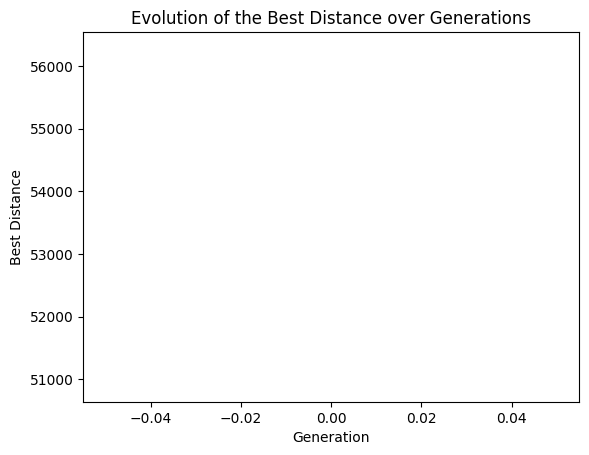

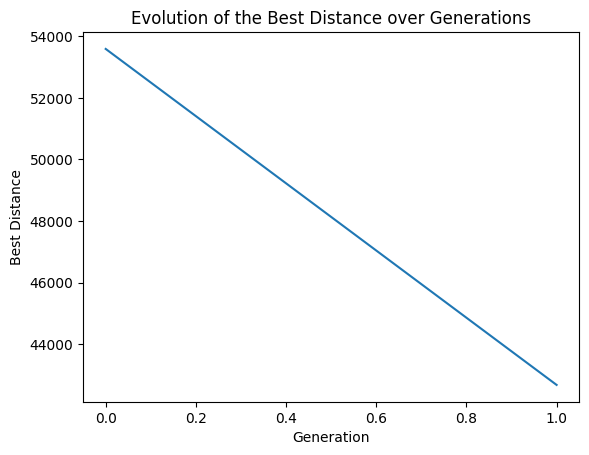

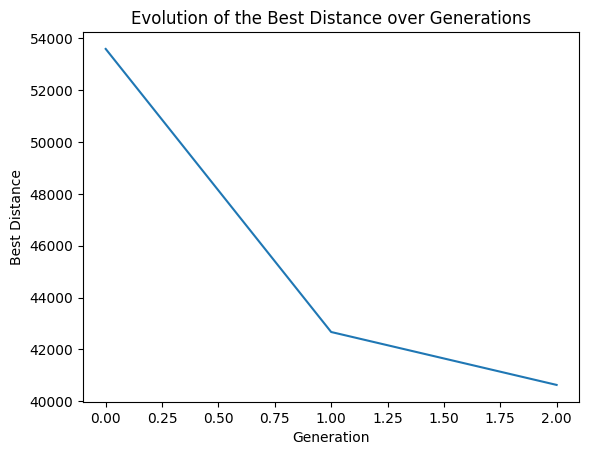

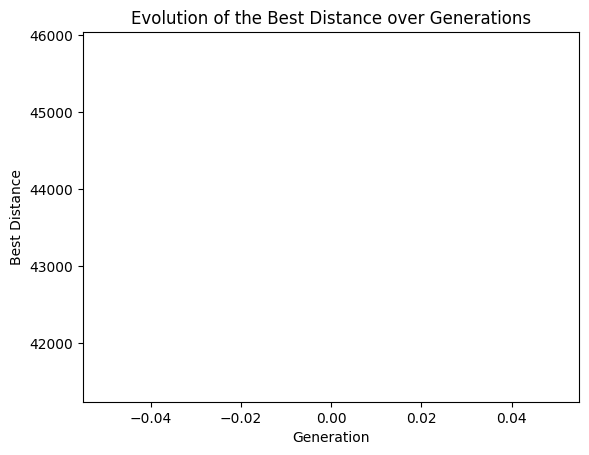

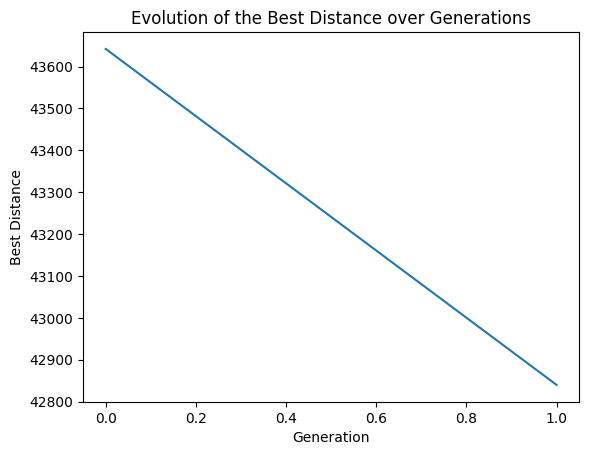

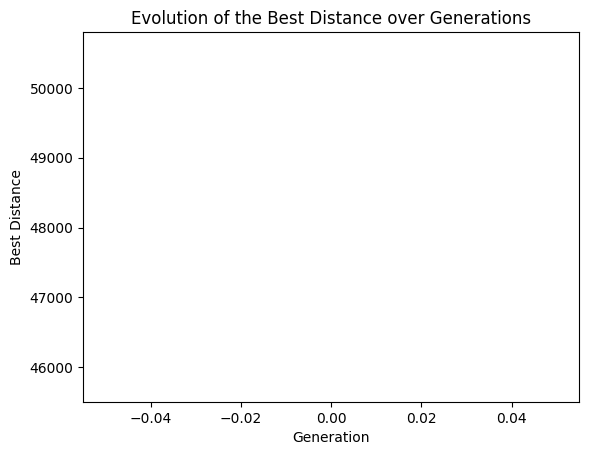

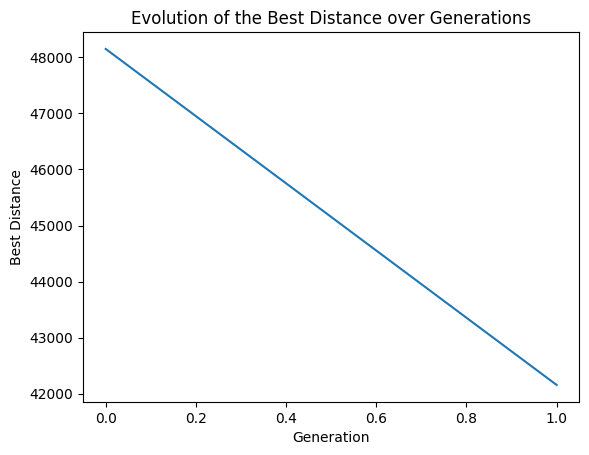

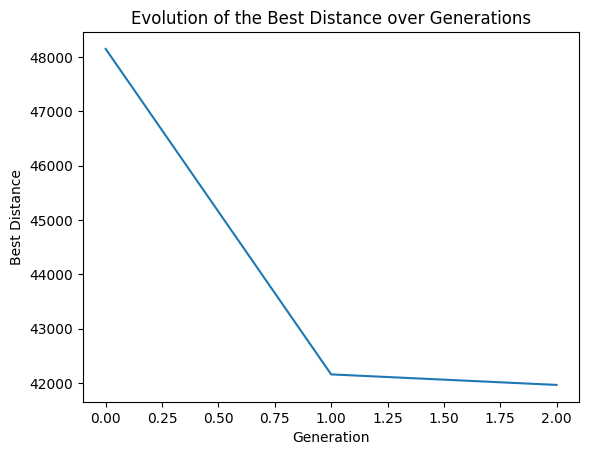

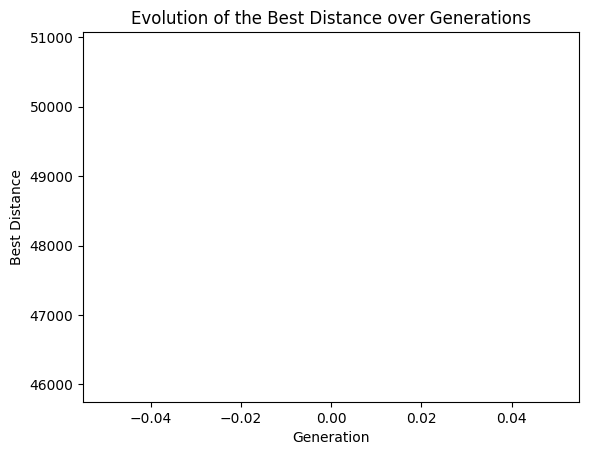

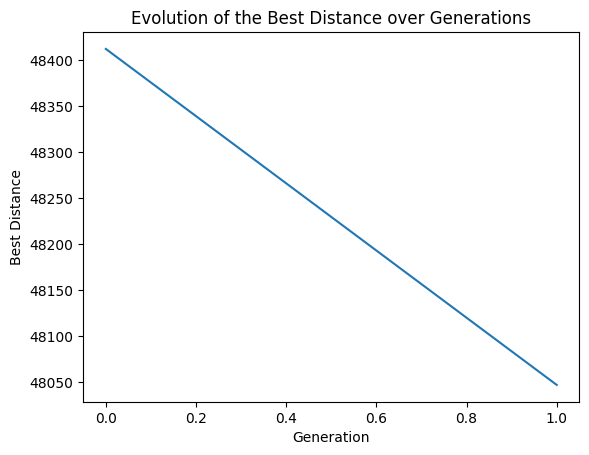

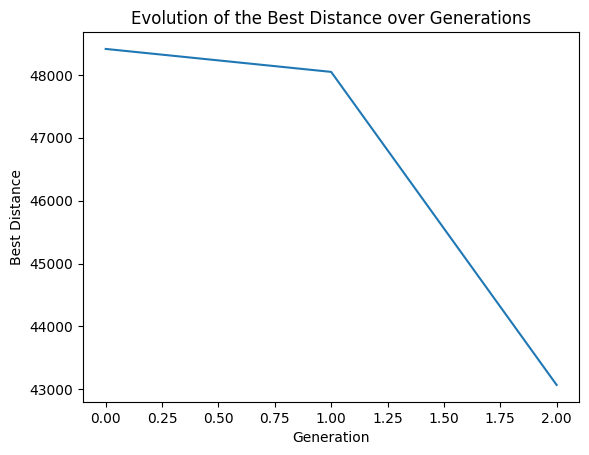

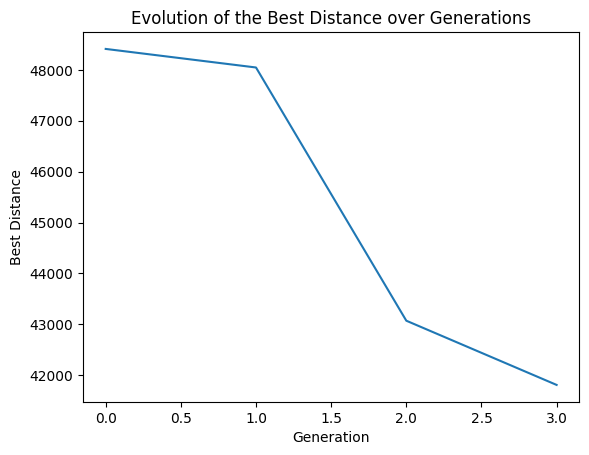

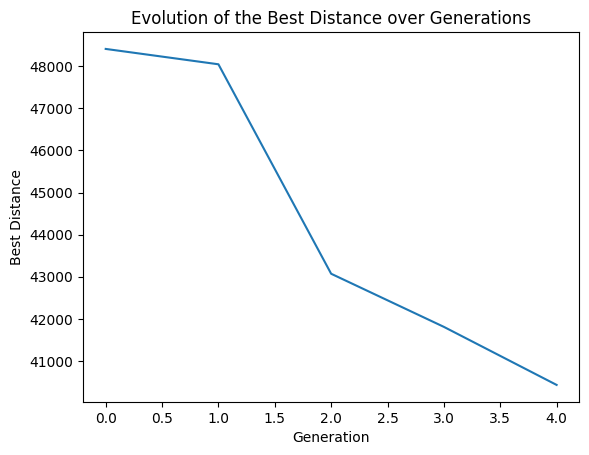

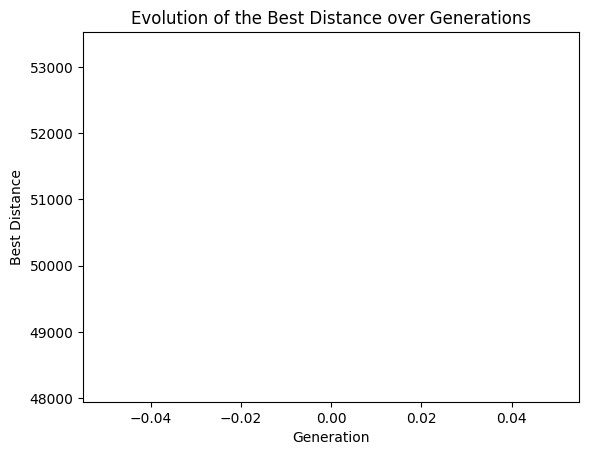

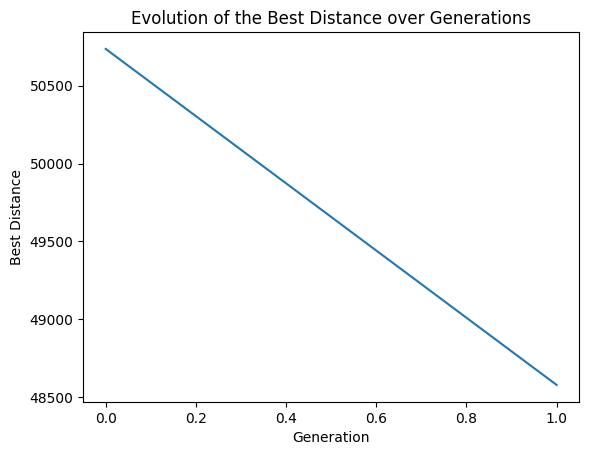

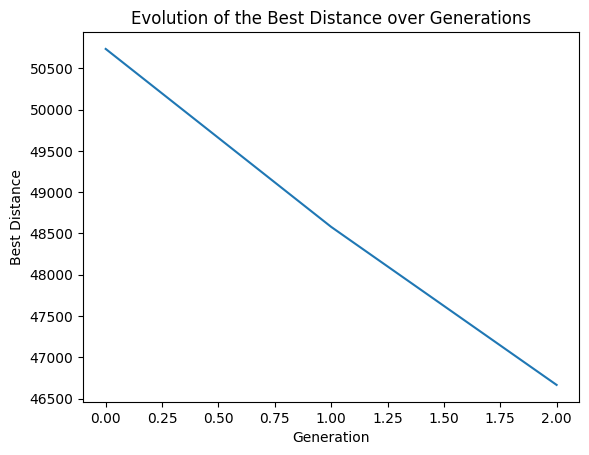

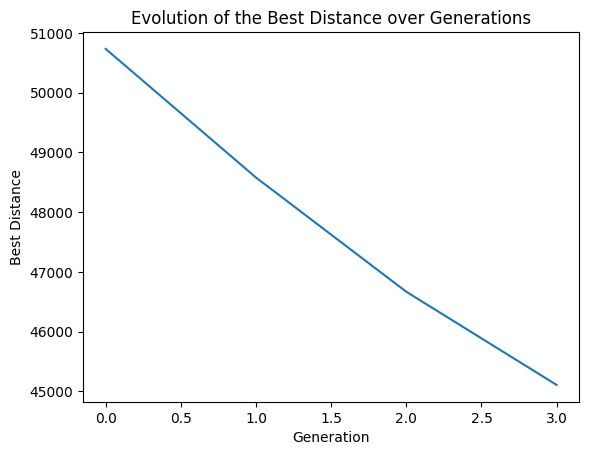

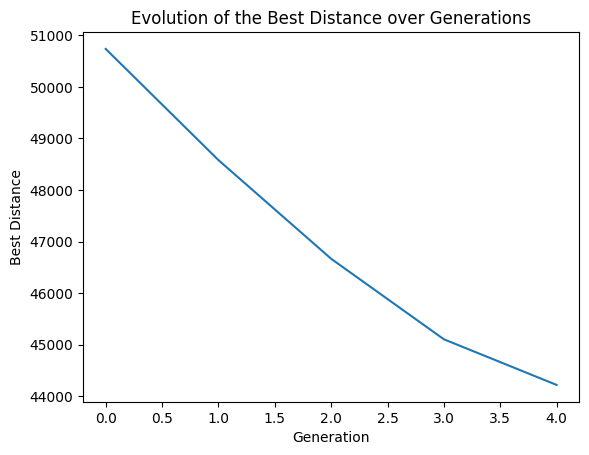

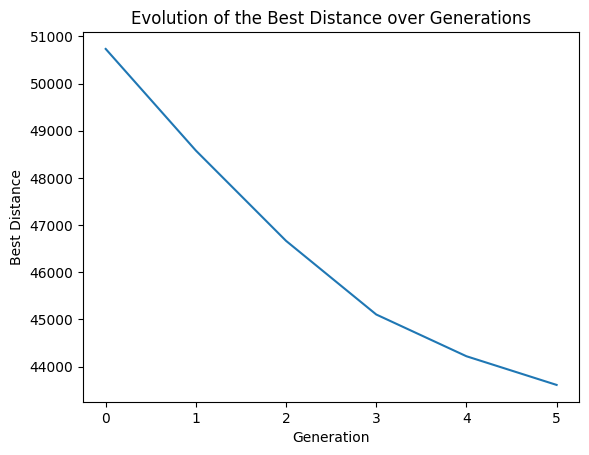

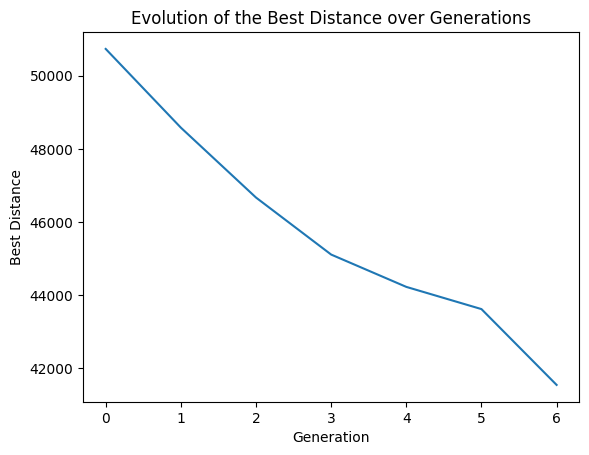

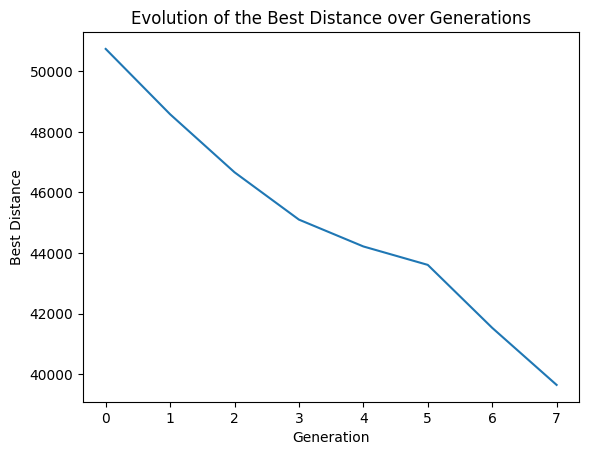

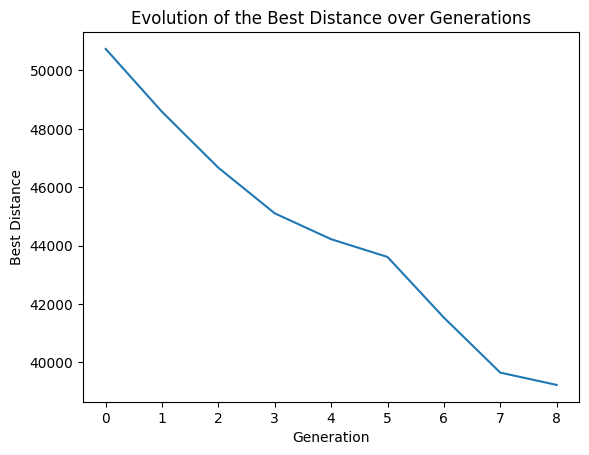

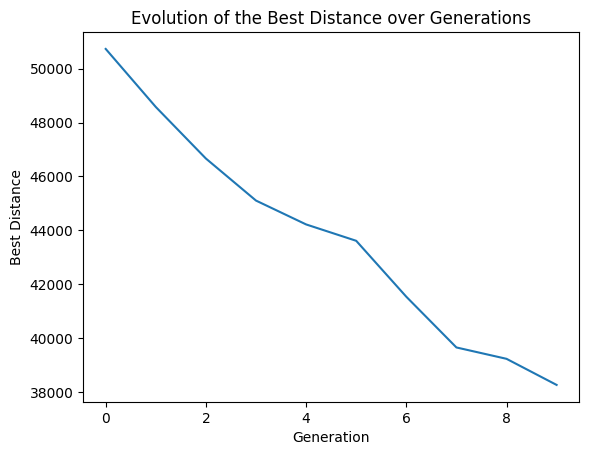

All test results saved to 'ga_tsp_test_results_att48.txt'.


In [172]:

import matplotlib.pyplot as plt
import numpy as np
import random
import tsplib95

# Load TSP data from a file
def load_tsp_data(filename):
    return tsplib95.load(filename)

# Create a random route
def create_route(problem):
    return np.random.permutation(range(1, problem.dimension + 1))

# Initialize a population of routes
def initialize_population(pop_size, problem):
    return [create_route(problem) for _ in range(pop_size)]

# Calculate the total distance of a route
def calculate_fitness(route, problem):
    adjusted_route = [city - 1 for city in route]
    total_distance = 0
    for i in range(len(adjusted_route)):
        start_city = adjusted_route[i]
        end_city = adjusted_route[(i + 1) % len(adjusted_route)]
        total_distance += problem.get_weight(start_city + 1, end_city + 1)
    return total_distance

# Tournament Selection
def tournament_selection(population, problem, k=3):
    selected = []
    for _ in range(len(population)):
        contenders = random.sample(population, k)
        best = min(contenders, key=lambda route: calculate_fitness(route, problem))
        selected.append(best)
    return selected

# Roulette Wheel Selection
def roulette_wheel_selection(population, problem):
    fitness_values = [calculate_fitness(route, problem) for route in population]
    max_fitness = max(fitness_values)
    adjusted_fitness = [max_fitness - fitness for fitness in fitness_values]
    total_fitness = sum(adjusted_fitness)
    selection_probs = [f / total_fitness for f in adjusted_fitness]
    selected_indices = np.random.choice(len(population), size=len(population), p=selection_probs)
    return [population[i] for i in selected_indices]

# Rank-Based Selection
def rank_based_selection(population, problem):
    ranked_population = sorted(population, key=lambda route: calculate_fitness(route, problem))
    ranks = range(1, len(ranked_population) + 1)
    total_rank = sum(ranks)
    selection_probs = [rank / total_rank for rank in ranks]
    selected_indices = np.random.choice(len(ranked_population), size=len(ranked_population), p=selection_probs)
    return [ranked_population[i] for i in selected_indices]

# Scramble Mutation
def scramble_mutation(route):
    mutated_route = route.copy()
    start, end = sorted(random.sample(range(len(route)), 2))
    scrambled_section = np.random.permutation(mutated_route[start:end+1])
    mutated_route[start:end+1] = scrambled_section
    return mutated_route

# Genetic Algorithm Function
def genetic_algorithm(problem, pop_size, generations, initial_mutation_rate, elite_size):
    # Initialize population and variables for tracking progress
    population = initialize_population(pop_size, problem)
    best_route = None
    best_distance = float('inf')
    best_distances_over_generations = []  # To track the best distance each generation

    # Main loop of the genetic algorithm
    for generation in range(generations):
        # Selection, crossover, and mutation steps...
        # After mutation, evaluate and update the best route and distance
        for route in population:
            distance = calculate_fitness(route, problem)
            if distance < best_distance:
                best_route = route
                best_distance = distance
                # Record the best distance of the current generation
                best_distances_over_generations.append(best_distance)
                
                # Plot the evolution of the best distance
                plt.plot(best_distances_over_generations)
                plt.xlabel('Generation')
                plt.ylabel('Best Distance')
                plt.title('Evolution of the Best Distance over Generations')
                plt.show()
                
        return best_route, best_distance


# Execution Block
tsp_file_path = "/Users/mwr/Downloads/NEC_A4/att48.tsp.txt"
problem = load_tsp_data(tsp_file_path)

test_cases = [
    (50, 100, 0.01, 1),
    (100, 200, 0.01, 2),
    (200, 300, 0.01, 5),
    (300, 400, 0.005, 15),
    (1000, 600, 0.00001, 500)
]

test_results = {}

for test in test_cases:
    pop_size, generations, mutation_rate, elite_size = test
    best_route, best_distance = genetic_algorithm(problem, pop_size, generations, mutation_rate, elite_size)
    test_results[test] = {"route": best_route, "distance": best_distance}

# Saving the results to a file
with open("ga_tsp_test_results_att48.txt", "w") as file:
    for params, result in test_results.items():
        file.write(f"Params: {params}, Best Route: {result['route']}, Total Distance: {result['distance']}\n")

print("All test results saved to 'ga_tsp_test_results_att48.txt'.")



In [167]:
print(best_distances_over_generations)

NameError: name 'best_distances_over_generations' is not defined